RAINSTORM

## Seize labels

- This notebook will help us visualize the results of labeled videos of an experiment

#### Requirements:

- The position.csv files processed by 1-Prepare_positions.ipynb
- Geolabels, autolabels or manual labels for those same positions

---
#### 1. Load the necessary modules

In [1]:
import os
import rainstorm.seize_labels as rst

---
#### 2. State your project path and experiment details
`base` : The path to the downloaded repository.

`groups` : Name the groups on your experiment.

`trials` : Name the trials on your experiment.

`objects` : Name the stationary objects that may appear on your data.

`label_type` : State which labels you want to use.

`t_lim` : If you want to cut short the analysis and focus on a shorter time window, state the end time for the analysis. Else, leave as None

`fps` : The frames per second of the video.

In [2]:
# State your path:
base = r'C:\Users\dhers\Desktop\RAINSTORM'
folder_path = os.path.join(base, r'docs\examples\NOR_example_copy')

groups = ['male', 'female']
trials = ['TS', 'TR', 'Hab']
objects = ['obj_1', 'obj_2']

label_type = 'autolabels'
t_lim = None # seconds
fps = 25

data = {group: {trial: objects for trial in trials} for group in groups}
data

{'male': {'TS': ['obj_1', 'obj_2'],
  'TR': ['obj_1', 'obj_2'],
  'Hab': ['obj_1', 'obj_2']},
 'female': {'TS': ['obj_1', 'obj_2'],
  'TR': ['obj_1', 'obj_2'],
  'Hab': ['obj_1', 'obj_2']}}

#### Copy the data dictionary and paste it below, changing the objects for their novelty (eg: ['Novel', 'Known'], ['Left', 'Right'] or None)

In [3]:
data = {
 'male': {'TS': ['Novel', 'Known'],
  'TR': ['Left', 'Right'],
  'Hab': None},
 'female': {'TS': ['Novel', 'Known'],
  'TR': ['Left', 'Right'],
  'Hab': None},
  }

---
#### 3. With the experiment details ready, we can create a reference file on our experiment folder.
We need to complete and use the reference file to tell the functions which groups and objects to use for each mouse.


In [4]:
# Lets create the reference.csv file
reference_path = rst.create_reference_file(folder_path, trials, objects)

CSV file 'C:\Users\dhers\Desktop\RAINSTORM\docs\examples\NOR_example_copy\reference.csv' created successfully with the list of video files.


---
#### 4. Go to the experiment folder and complete the 'reference.csv' file
If you are using the NOR_example folder to try out rainstorm, you will find a copy of the reference file **already completed** inside the 'h5 files & others' folder.

All you need to do is move it to the experiment folder or copy its contents into the 'reference.csv' file.

Once you have completed the reference file, you can proceed to the next step where we will use it to create the 'summary' folder.

In [5]:
# Lets rename the labels
summary_path = rst.create_summary(reference_path, label_type, trials, objects, fps)

Renamed and saved: C:\Users\dhers\Desktop\RAINSTORM\docs\examples\NOR_example_copy\summary\male\TS\NOR_TS_C1_A_summary.csv
Renamed and saved: C:\Users\dhers\Desktop\RAINSTORM\docs\examples\NOR_example_copy\summary\female\TS\NOR_TS_C1_B_summary.csv
Renamed and saved: C:\Users\dhers\Desktop\RAINSTORM\docs\examples\NOR_example_copy\summary\female\TS\NOR_TS_C1_C_summary.csv
Renamed and saved: C:\Users\dhers\Desktop\RAINSTORM\docs\examples\NOR_example_copy\summary\male\TS\NOR_TS_C1_D_summary.csv
Renamed and saved: C:\Users\dhers\Desktop\RAINSTORM\docs\examples\NOR_example_copy\summary\female\TS\NOR_TS_C2_A_summary.csv
Renamed and saved: C:\Users\dhers\Desktop\RAINSTORM\docs\examples\NOR_example_copy\summary\male\TS\NOR_TS_C2_B_summary.csv
Renamed and saved: C:\Users\dhers\Desktop\RAINSTORM\docs\examples\NOR_example_copy\summary\male\TS\NOR_TS_C2_C_summary.csv
Renamed and saved: C:\Users\dhers\Desktop\RAINSTORM\docs\examples\NOR_example_copy\summary\female\TS\NOR_TS_C2_D_summary.csv
Renamed 

---
#### 5. With our files ready, all is left to do is to run the analysis and plot the results.

We can plot distance traveled, exploration for each object, freezing time, and more!

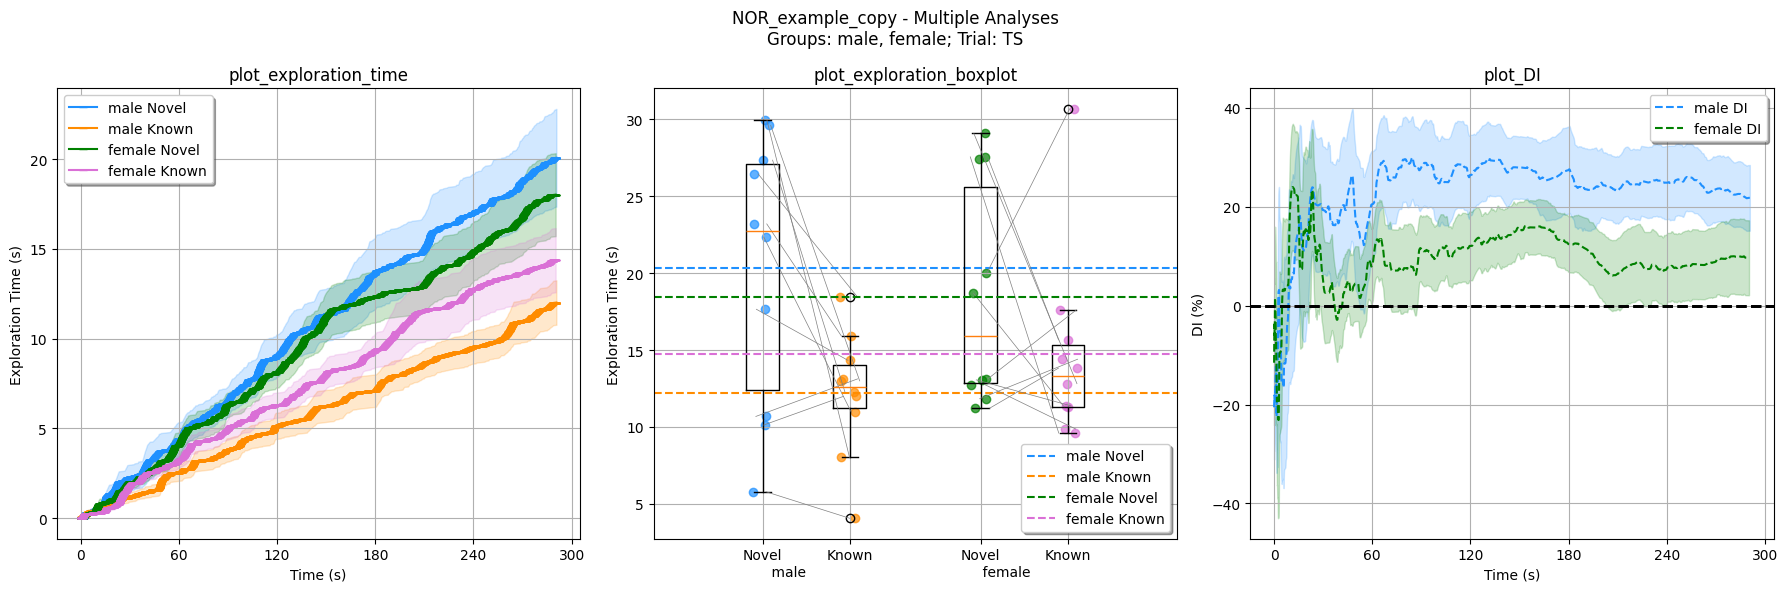

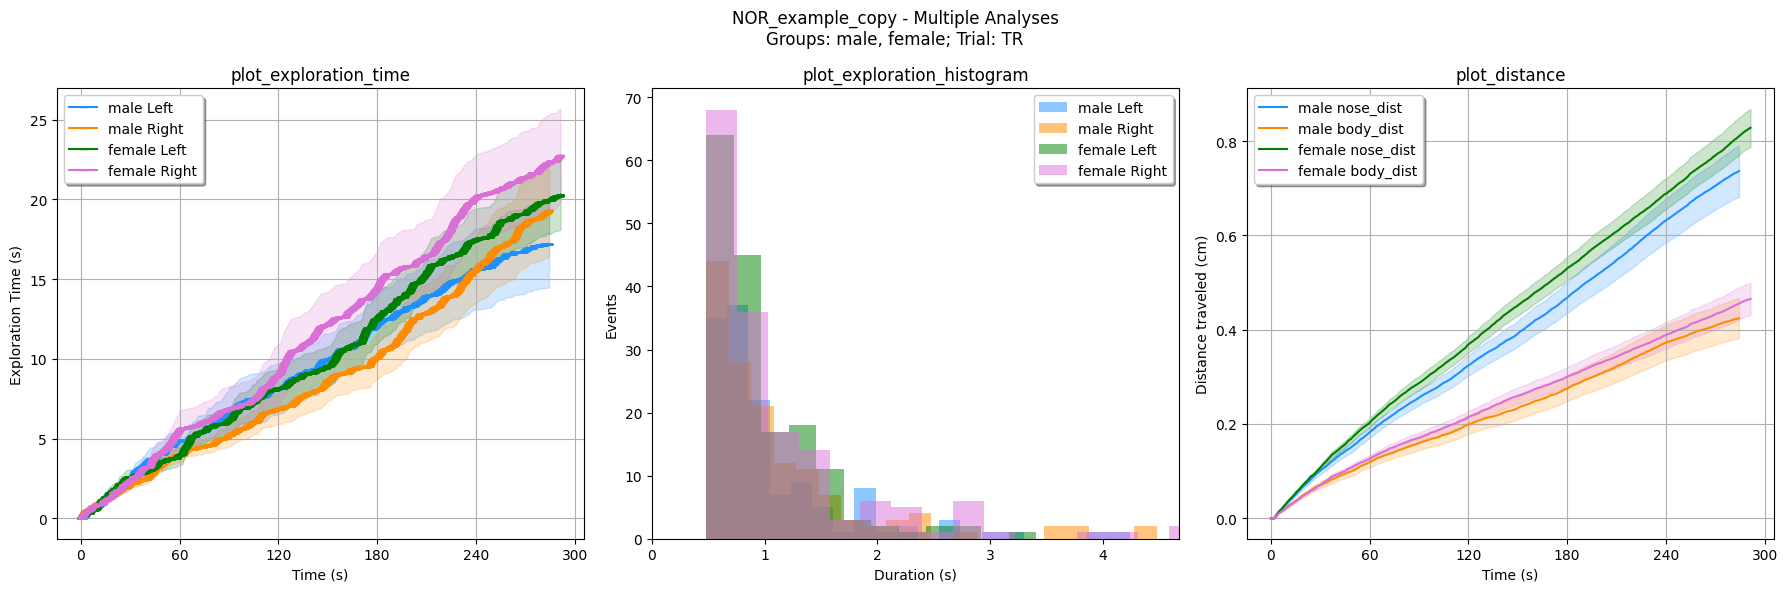

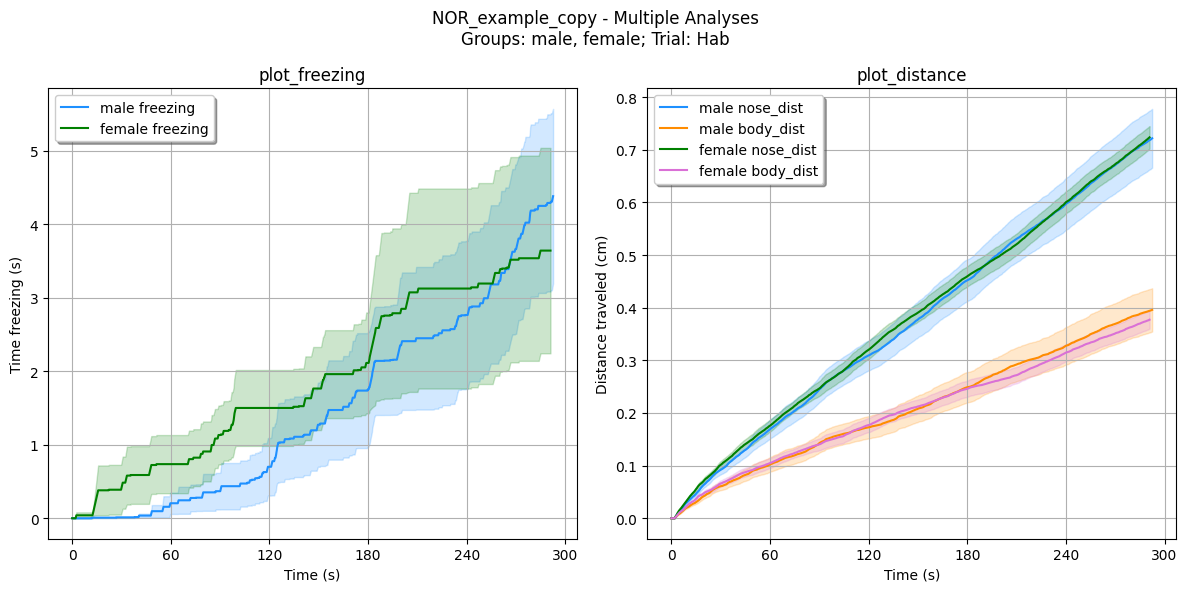

In [7]:
rst.plot_multiple_analyses(folder_path, data, groups, 'TS', [rst.plot_exploration_time, rst.plot_exploration_boxplot, rst.plot_DI], fps)
rst.plot_multiple_analyses(folder_path, data, groups, 'TR', [rst.plot_exploration_time, rst.plot_exploration_histogram, rst.plot_distance], fps)
rst.plot_multiple_analyses(folder_path, data, groups, 'Hab', [rst.plot_freezing, rst.plot_distance], fps)

---
---
#### These modular graphs are intended to show the dynamic behavior of mice, providing a deeper insight into what happens with learning and memory.

We have reached the end of this project. If you have read and followed the code up to this point, I want to thank you for your time and attention. If you have any questions, complaints and/or suggestions, do not hesitate to write me: simple.torm@gmail.com


---
RAINSTORM - Created on Jun 25, 2024 - @author: Santiago D'hers